# NA 565 Example Session 2 - Model Predictive Control

In the example session, we will implement the Model Predictive Control (MPC) using CVX. 

We will discuss:


1. The implementation of tracking control using Quadratic Programming (QP), 

2. and its comparison with LQR;

3. sufficient condition on recursive stability,

4. and the influence of terminal cost design. 

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

# Tracking control of nonlinear system

We consider the nonlinear system:

$$
s_{k+1} = f(s_k, u_k).
$$

Given the reference trajectory $\left(\bar{s}_{k}, \bar{u}_{k}\right)_{k=0,1,2,\cdots, N-1}$, we have the linearized system as:

$$ s_{k+1} - \bar{s}_{k+1} = f(s_k, u_k) - f(\bar{s}_k, \bar{u}_k),$$

$$ s_{k+1} - \bar{s}_{k+1} = \frac{\partial f(s_k, u_k)}{\partial s_k}|_{\bar{s}_k}(s_{k} - \bar{s}_k) + \frac{\partial f(s_k, u_k)}{\partial u_k}|_{\bar{u}_k}(u_{k} - \bar{u}_k) + h.o.t(s_{k} - \bar{s}_k, u_{k} - \bar{u}_k),$$ 
$$ \delta s_{k+1} = \frac{\partial f(s_k, u_k)}{\partial s_k}|_{\bar{s}_k} \delta s_{k} + \frac{\partial f(s_k, u_k)}{\partial u_k}|_{\bar{u}_k} \delta u_{k} + h.o.t(\delta s_k, \delta u_k),$$
where $h.o.t(\cdot,\cdot)$ denotes the terms with order higher than 1 and are omitted. 

Then we have the perturbed state dynamics as:

$$ \delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_{k}, $$ 
with $A_k:= \frac{\partial f(s_k, u_k)}{\partial s_k}|_{\bar{s}_k}$ and $B_k := \frac{\partial f(s_k, u_k)}{\partial u_k}|_{\bar{u}_k}.$

Then we can derive the controller alone $\left(\bar{s}_{k}, \bar{u}_{k}\right)_{k=0,1,2,\cdots, N-1}$ to regulerize $\delta s_k$ to 0. 

## LQR (unconstrained input)

$$
    \begin{aligned}
    \min_{\delta s_k, \delta u_k} & \ \delta s_N^TP\delta s_N + \sum_{k=0}^{N-1} \delta s_k^TQ\delta s_k + \delta u_k^TR\delta u_k \\ 
    \text{s.t. } &\delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_k, \ k = 0, \dots, N-1, \\
                 &\delta s_0 = \delta s_{init}.
    \end{aligned}
$$

## MPC (with input constraints):

$$
    \begin{aligned}
    \min_{\delta s_k, \delta u_k} & \ \delta s_N^TP\delta s_N + \sum_{k=0}^{N-1} \delta s_k^TQ\delta s_k + \delta u_k^TR\delta u_k \\ 
    \text{s.t. } &\delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_k, \ k = 0, \dots, N-1, \\
                 & {\color{red}u_{\min} - \bar{u}_k \le \delta u_k \le u_{\max} - \bar{u}_k,} \\
                 &\delta s_0 = \delta s_{init}.
    \end{aligned}
$$

## Examples on point car model
Consider this point car model, with $s:= [x, y, \psi, v]^{T}$ and $u:= [\delta, a]^T$. 
$$
\begin{aligned}

\dot{x} &= v\cos(\psi) \\
\dot{y} &= v\sin(\psi) \\
\dot{\psi} &= \frac{v}{L}\tan(\delta) \\
\dot{v}&=a

\end{aligned}
$$

We consider the Euler first-order integration: $s_{k+1} = s_k + f(s_k , u_k) \Delta t$, where $f(s, u)$ is the above continuous time dynamics. 

Then we have the Jacobians as:

$$
A := I_4 + \Delta t\begin{bmatrix} 
            0 & 0 & v\sin(\psi) & \cos(\psi) \\
            0 & 0 & v\cos(\psi) & \sin(\psi) \\
            0 & 0 & 0 & \frac{\tan\delta}{L} \\
            0 & 0 & 0 & 0 \\
           \end{bmatrix}
$$

$$
B := \Delta t\begin{bmatrix} 
            0 & 0  \\
            0 & 0  \\
            \frac{v}{L}\left( \tan^2\delta + 1\right) & 0  \\
            0 & 1  \\
           \end{bmatrix}
$$

In [2]:
class CarSim:
    def __init__(self, param):
        self.Dim_state = 4
        self.Dim_ctrl  = 2
    
        self.L = param["L"]
        self.h   = param["h"]
        self.T   = param["T"]

        self.a_lim     = np.array([param["lb"][1], param["ub"][1]])
        self.delta_lim = np.array([param["lb"][0], param["ub"][0]])
                
        self.Ns = int(np.ceil(self.T / self.h))
    
    def Fun_dynamics_dt(self, x, u):

        xdot = np.zeros(4)        

        xdot[0] = x[3] * np.cos(x[2])
        xdot[1] = x[3] * np.sin(x[2])
        xdot[2] = x[3] / self.L * np.sin(u[0])
        xdot[3] = u[1]
    
        xkp1 = x + xdot * self.h

        return xkp1
        
    def SimVehicle(self, x_bar, u_bar, preview, x0, controller, noisy):
    
        x_log = x_bar * 0.
        u_log = u_bar * 0.
        obj_log = u_bar[:, 0] * 0.

        x_log[0, :] = x0

        x_bar_ext = np.concatenate((x_bar, np.ones((preview, x_log.shape[1])) * x_log[-1, :] ))
        u_bar_ext = np.concatenate((u_bar, np.ones((preview, u_log.shape[1])) * u_log[-1, :]))

        perturb = np.random.randn(x_log.shape[0], x_log.shape[1]) * 0.05

        for k in range(self.Ns):
            
            output = controller(x_bar_ext[k:k+preview+1, :], u_bar_ext[k:k+preview, :], x_log[k, :])

            u_act = output[0]
            obj = output[1]

            u_act[0] = np.clip(u_act[0],  self.delta_lim[0], self.delta_lim[1])
            u_act[1] = np.clip(u_act[1],  self.a_lim[0], self.a_lim[1])

            if noisy:
                x_log[k + 1, :] = np.squeeze(self.Fun_dynamics_dt(x_log[k, :],   u_act)) + perturb[k, :]
            else:
                x_log[k + 1, :] = np.squeeze(self.Fun_dynamics_dt(x_log[k, :],   u_act))

            u_log[k, :]     = np.squeeze(u_act)
            obj_log[k] = obj

        return x_log, u_log, obj_log
    
    def GenRef(self, alpha, beta):
        # generate a nominal trajectory
        x_bar = np.zeros((self.Ns + 1, self.Dim_state))
        u_bar = np.zeros((self.Ns    , self.Dim_ctrl))

        for k in range(self.Ns):
            u_act = np.array([np.cos(k / 10 / alpha) * 0.5 + 0.5 * np.sin(k / 10 / np.sqrt(beta)),
                              - 1 * (x_bar[k, 3] - 8 + 10 * np.sin(k / 20) + np.sin(k / np.sqrt(7))) ])

            u_act[0] = np.clip(u_act[0],  self.delta_lim[0], self.delta_lim[1])
            u_act[1] = np.clip(u_act[1],  self.a_lim[0], self.a_lim[1])
            
            u_bar[k, :]     = np.squeeze(u_act)
            x_bar[k + 1, :] = np.squeeze(self.Fun_dynamics_dt(x_bar[k, :],   u_act))
            
        return u_bar, x_bar

In [3]:
import numpy as np
import cvxpy as cp

def Fun_Jac_dt(x, u, param):

    L = param["L"]
    h   = param["h"]

    psi = x[2]
    v   = x[3]
    delta = u[0]
    a   = u[1]
    
    A = np.zeros((4, 4))
    B = np.zeros((4, 2))

    A[0, 0] = 1.0
    A[0, 2] = -h*v*np.sin(psi)
    A[0, 3] = h*np.cos(psi)

    A[1, 1] = 1.0
    A[1, 2] = h*v*np.cos(psi)
    A[1, 3] = h*np.sin(psi)

    A[2, 2] = 1.0
    A[2, 3] = h * np.tan(delta) / L
    
    A[3, 3] = 1.0

    B[2, 0] = (h*v)/L * (np.tan(delta)**2 + 1)
    B[3, 1] = h

    return [A, B]

def Controller(x_bar, u_bar, x0, Fun_Jac_dt, param):
    dim_state = x_bar.shape[1]
    dim_ctrl  = u_bar.shape[1]
    
    n_u = u_bar.shape[0] * u_bar.shape[1]
    n_x = x_bar.shape[0] * x_bar.shape[1]
    n_var = n_u + n_x

    n_eq  = x_bar.shape[1] * u_bar.shape[0] # dynamics
    n_ieq = u_bar.shape[1] * u_bar.shape[0] # input constraints
    
    # define the parameters
    Q = param["Q"] 
    R = param["R"] 
    Pt = param["P"]
    
    # define the cost function
    np.random.seed(1)
    P = np.zeros((n_var, n_var))
    for k in range(u_bar.shape[0]):
        P[k * x_bar.shape[1]:(k+1) * x_bar.shape[1], k * x_bar.shape[1]:(k+1) * x_bar.shape[1]] = Q
        P[n_x + k * u_bar.shape[1]:n_x + (k+1) * u_bar.shape[1], n_x + k * u_bar.shape[1]:n_x + (k+1) * u_bar.shape[1]] = R
    
    P[n_x - x_bar.shape[1]:n_x, n_x - x_bar.shape[1]:n_x] = Pt
    P = (P.T + P) / 2
    q = np.zeros((n_var, 1))
    
    # define the constraints
    A = np.zeros((n_eq, n_var))
    b = np.zeros(n_eq)
    
    G = np.zeros((n_ieq, n_var))
    ub = np.zeros(n_ieq)
    lb = np.zeros(n_ieq)
    
    u_lb = param["lb"]
    u_ub = param["ub"]
    
    for k in range(u_bar.shape[0]):

        ## iterate the list of reference trajectory to obtain the linearized dynamics
        AB = Fun_Jac_dt(x_bar[k, :], u_bar[k, :], param)
        A[k * dim_state:(k+1) * dim_state,      k * dim_state:(k+1) * dim_state]       = AB[0] # AB[0:dim_state, 0:dim_state]
        A[k * dim_state:(k+1) * dim_state,  (k+1) * dim_state:(k+2) * dim_state]       = -np.eye(dim_state)
        A[k * dim_state:(k+1) * dim_state, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl]  = AB[1] # AB[0:dim_state, dim_state:]
        
        G[k * dim_ctrl:(k+1) * dim_ctrl, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl]    = np.eye(dim_ctrl)
        ub[k * dim_ctrl:(k+1) * dim_ctrl] = u_ub - u_bar[k, :]
        lb[k * dim_ctrl:(k+1) * dim_ctrl] = u_lb - u_bar[k, :]

    # Define and solve the CVXPY problem.
    x = cp.Variable(n_var)

    cons = [A @ x == b,
            x[0:dim_state] == x0 - x_bar[0, :]
           ]

    if param["mode"] == "MPC":
        cons.append(G @ x <= ub)
        cons.append(lb <= G @ x)
        
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                     cons)
    prob.solve(verbose=False, max_iter = 10000)
    
    return [x.value[n_x:n_x + dim_ctrl] + u_bar[0, :], prob.objective.value, np.reshape(x.value[n_x:], u_bar.shape) + u_bar ]

## Applying LQR

In [4]:
param = {"h":0.05, "T":15., "L": 1., "ub": [0.8, 2.], "lb": [-0.8, -2.0], "mode": "LQR", "P": np.eye(4) * 100, "Q": np.eye(4) * 10, "R": np.eye(2)}
Sim = CarSim(param)
u_bar, x_bar = Sim.GenRef(10, 23)

preview = 20
x0 = np.array([2, 2, 3.14, 4])
x_log, u_log, obj_log = Sim.SimVehicle(x_bar, u_bar, preview, x0, lambda x, u, xinit: Controller(x, u, xinit, Fun_Jac_dt, param), noisy=False)

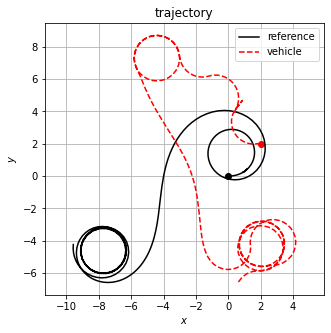

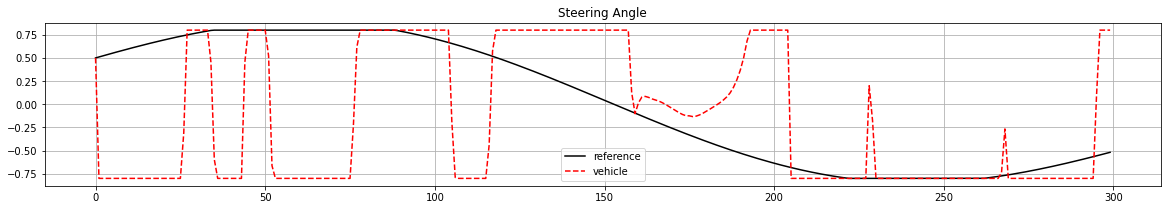

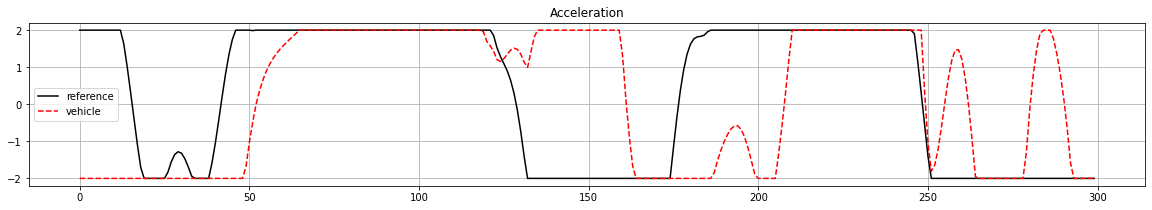

In [5]:
plt.figure(figsize=(5, 5))
plt.plot(x_bar[0, 0], x_bar[0, 1], 'ko-')
plt.plot(x_log[0, 0], x_log[0, 1], 'ro-')
plt.plot(x_bar[:, 0], x_bar[:, 1], 'k-', label = "reference")
plt.plot(x_log[:, 0], x_log[:, 1], 'r--', label = "vehicle")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 0], 'k-', label = "reference")
plt.plot(u_log[:, 0], 'r--', label = "vehicle")
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 1], 'k-', label = "reference")
plt.plot(u_log[:, 1], 'r--', label = "vehicle")
plt.title('Acceleration')
plt.legend()
plt.grid()
plt.show()

## Applying MPC

In [6]:
param["mode"] = "MPC"
Sim = CarSim(param)
u_bar, x_bar = Sim.GenRef(10, 23)

preview = 20
x0 = np.array([2, 2, 3.14, 4])
x_log, u_log, obj_log = Sim.SimVehicle(x_bar, u_bar, preview, x0, lambda x, u, xinit: Controller(x, u, xinit, Fun_Jac_dt, param), noisy=False)

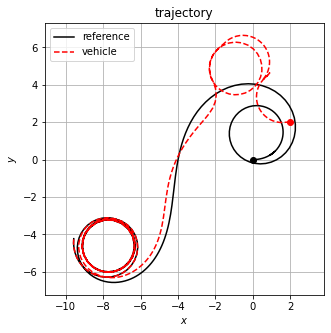

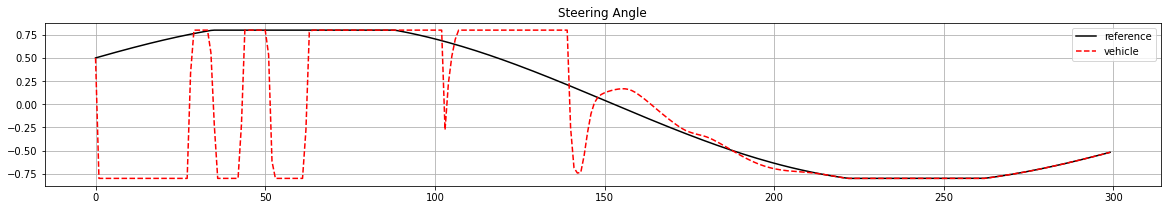

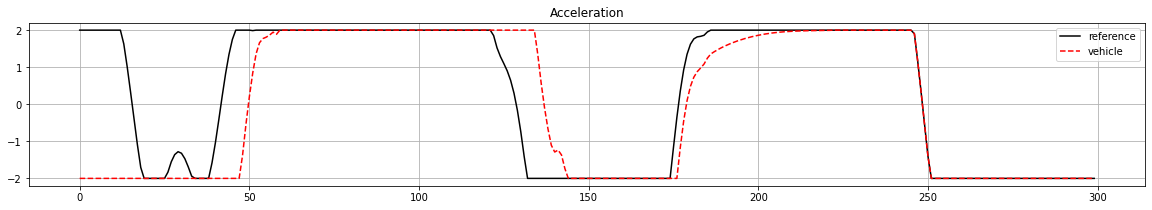

In [7]:
plt.figure(figsize=(5, 5))
plt.plot(x_bar[0, 0], x_bar[0, 1], 'ko-')
plt.plot(x_log[0, 0], x_log[0, 1], 'ro-')
plt.plot(x_bar[:, 0], x_bar[:, 1], 'k-', label = "reference")
plt.plot(x_log[:, 0], x_log[:, 1], 'r--', label = "vehicle")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 0], 'k-', label = "reference")
plt.plot(u_log[:, 0], 'r--', label = "vehicle")
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 1], 'k-', label = "reference")
plt.plot(u_log[:, 1], 'r--', label = "vehicle")
plt.title('Acceleration')
plt.legend()
plt.grid()
plt.show()


## Stability of MPC

Observation 1: Each iteration of MPC is to optimize the performance over a finite horizon. 

Observation 2: In practice, the MPC ensures the stability for all time (when the disturbance are within some reasonable range).

We introduce a sufficient condition for recursive stability. We show that as long the cost function is properly designed, it will decrease along the entire closed-loop trajectory. 

The following theorem are mainly based on Theorem 12.2 in the reference listed at the end of this notebook. 

### System definition

Consider the MPC problem
$$
    \begin{aligned}
    J_0^{*}(x_{init}) = \min_{x_k, u_k} & \ p(x_N) + \sum_{k=0}^{N-1} q(x_k, u_k)\\ 
    \text{s.t. } 
                %  & x_{k+1} =  \ k = 0, \dots, N-1, \\
                & x_{k+1} = f(x_k, u_k), k = 0, \dots, N-1, \\
                & x_0 = x_{init}, \\
                & u_k \in \mathcal{U}, \\
                & x_k \in \mathcal{X}, x_N \in \mathcal{X_f}.
    \end{aligned}
$$

The $\mathcal{X}$ is the set of feasible states, $\mathcal{X}_f$ is the control invariant sets, and $\mathcal{U}$ is the set of allowable control inputs. 

The control invariant set $\mathcal{X}_f$ denotes “the set of initial states for
which there exists a controller such that the system constraints are never violated”, whose formal definition is: 

$\mathcal{X}_f$ is control invariant for system $x_{k+1} = f(x_k, u_k)$, if $\forall x \in \mathcal{X}_f$, $\exist u$, such that $f(x, u) \in \mathcal{X}_f$. 

The $\mathcal{X}_f$ is a regularization condition that ensures the existence of such control inputs to make the problem feasible. 

We denote the control law of this MPC by $u_t= \pi(x_t)$. The closed-loop system is denoted by: 

$$
    x_{k+1} = f(x_k, \pi(x_k)) =: f_{cl}(x_k). 
$$


### Example of contorl invariant set $\mathcal{X}_f$

Consider the 1d linear system:

$$x_{k+1} = 1.1 x_k + 0.02u_k, -10 \le u_k \le 10$$

$$\mathcal{X}_f = \{x | -2 \le x \le 2\}. $$

### Sufficient condition of recursive stability

#### Assumptions:

(A0) The stage cost $q(x, u)$ and terminal cost $p(x)$ are continuous and positive definite functions.

(A1) The sets $\mathcal{X}, \mathcal{X}_f$ and $\mathcal{U}$ contain the origin in their interior and are closed.

(A2) $\mathcal{X}_f$ is control invariant, $\mathcal{X}_f \subseteq \mathcal{X}$.

(A3) $$ \min_{v \in \mathcal{U}, f(x, v) \in \mathcal{X}_f}(-p(x)+q(x, v)+p(f(x, v))) \leq 0, \forall x \in \mathcal{X}_f. $$

<!-- (A4) The suboptimal control input $\tilde{U}_0(x)$ satisfies $J_0\left(x, \tilde{U}_0(x)\right) \leq J_0^*(x)+\gamma(x), \forall x \in \mathcal{X}_0$, with $\gamma \succeq 0$ a positive semidefinite function.

(A5) $ \gamma(x)-q(x, 0) \prec 0, \forall x \in \mathcal{X}_0, x \neq 0$. -->

**If assumotions (A0-A3) are satisfied, the origin of the closed-loop system $x_{k+1} = f_{cl}(x_k)$ is stable asymptotically, in the sense "that the cost function of the MPC is decreasing all the time".**

#### Proof (asymtotic stability part):

Suppose the **optimal** trajectory generated by solving the MPC with initial state $\bar{x}_0$:

$$
\begin{aligned}
{X}^*_0 &= \{\bar{x}_0, \bar{x}_1, \bar{x}_2, \cdots, \bar{x}_{N-1}, \bar{x}_N  \}, \\
{U}^*_0 &= \{\bar{u}_0, \bar{u}_1, \bar{u}_2, \cdots, \bar{u}_{N-1}  \}.
\end{aligned}
$$

with the cost: 

$$
{J}^*(\bar{x}_0) = p(\bar{x}_N) + \sum_{k=0}^{N-1} q(\bar{x}_k, \bar{u}_k)
$$

Now we consider the executation of the MPC at the next time step, i.e. $k=1$, with initial states $\bar{x}_{1} = f(\bar{x}_0, \bar{u}_0)$. 

Now we consider an **suboptimal** trajectory, which overlap with the $X^*_0$ and $U^*_0$ except the last step:

$$
\begin{aligned}
\tilde{X}_1 &= \{\bar{x}_1, \bar{x}_2, \bar{x}_3, \cdots, \bar{x}_{N}, \bar{x}_{N+1}  \}, \\
\tilde{U}_1 &= \{\bar{u}_1, \bar{u}_2, \bar{u}_3, \cdots, \bar{u}_{N}  \}.
\end{aligned}
$$

with the cost: 

$$
\begin{aligned}
\tilde{J}(\bar{x}_1) &= p(\bar{x}_{N+1}) + \sum_{k=1}^{N} q(\bar{x}_k, \bar{u}_k) \\
&=p(\bar{x}_{N+1}) + q(\bar{x}_N, \bar{u}_N) + \sum_{k=1}^{N-1} q(\bar{x}_k, \bar{u}_k) \\
&=p(\bar{x}_{N+1}) + q(\bar{x}_N, \bar{u}_N) + \sum_{k=0}^{N-1} q(\bar{x}_k, \bar{u}_k) - q(\bar{x}_0, \bar{u}_0) 
\end{aligned}
$$

Then we compare the suboptimal cost with the optimal cost:

$$
{J}(\bar{x}_1)^* \le \tilde{J}(\bar{x}_1) = {J}^*(\bar{x}_0) + p(\bar{x}_{N+1}) + q(\bar{x}_N, \bar{u}_N) - p(\bar{x}_N) - q(\bar{x}_0, \bar{u}_0) 
$$

By (A3), we have $ \exist u_N, p(\bar{x}_{N+1}) + q(\bar{x}_N, \bar{u}_N) - p(\bar{x}_N) \le 0$, then we have:

$$
{J}(\bar{x}_1)^* \le \tilde{J}(\bar{x}_1) = {J}^*(\bar{x}_0) - q(\bar{x}_0, \bar{u}_0).
$$

As the $\bar{x}_0 \in \mathcal{X}$ is arbiterary and with (A0), we have: 

$$\forall x \in \mathcal{X}, \exist u, J^*(f(x, u)) - J^*(x) < 0. $$

Now we have shown that the cost will decrease along the closed-loop trajectory. 

For the rest of the proof, please refer to the reference book. 

## What can we do using this theorem? 

1. Design cost function to ensure stability.

2. System analysis: if / when /why the closed-loop system is stable. 

## Example: one-step MPC with proper terminal cost.

MPC with horizon equal to 1 can still stablize the system, as long as the terminal cost function is properly selected. 

In [8]:
def Jac_Lin(x, u, param):

    h = param["h"]

    A = np.array([[0, 1, 0],
                  [-1, 0, 0],
                  [0, 0, 5]]) ## Unstable case. About the eigen values, 

    
    B = np.array([[0, 0],
                  [1, 0],
                  [0, 1]])
    
    Ad = np.eye(3) + A * h
    Bd = (np.eye(3) * h) @ B
    return [Ad, Bd]

AB = Jac_Lin([], [], param)

print("Ad is: ")
Ad = AB[0]
print(Ad)

print("Bd is: ")
Bd = AB[1]
print(Bd)

Ad is: 
[[ 1.    0.05  0.  ]
 [-0.05  1.    0.  ]
 [ 0.    0.    1.25]]
Bd is: 
[[0.   0.  ]
 [0.05 0.  ]
 [0.   0.05]]


In [9]:
## closed-loop
def sim_LinSys_cl(x0, Ad, Bd, controller, N_sim, preview, noisy):

    dim_state = Ad.shape[0]
    dim_ctrl  = Bd.shape[1]

    x_log = np.zeros((N_sim + 1, dim_state))
    perturb = np.random.randn(x_log.shape[0], x_log.shape[1]) * 0.05

    u_log = np.zeros((N_sim, dim_ctrl ))
    obj_log = np.zeros((N_sim, 1))

    x_log[0, :] = np.squeeze(x0)

    for k in range(N_sim):

        output = controller(np.zeros((preview + 1, dim_state)), np.zeros((preview, dim_ctrl )), x_log[k, :])
        u_act = output[0]
        obj_log[k] = output[1]

        u_act = np.reshape(u_act, [dim_ctrl, 1])

        if noisy:
            xkp1 = Ad @ np.reshape(x_log[k, :], [dim_state, 1])  + Bd @ u_act + np.reshape(perturb[k, :], [dim_state, 1])
        else:
            xkp1 = Ad @ np.reshape(x_log[k, :], [dim_state, 1])  + Bd @ u_act

        x_log[k + 1, :] = np.squeeze(xkp1)
        u_log[k, :]     = np.squeeze(u_act)
    
    return x_log, u_log, obj_log

## LQR with short preview

Remember the result from last example session, short preview horizon can result in unstable closed-loop system. 

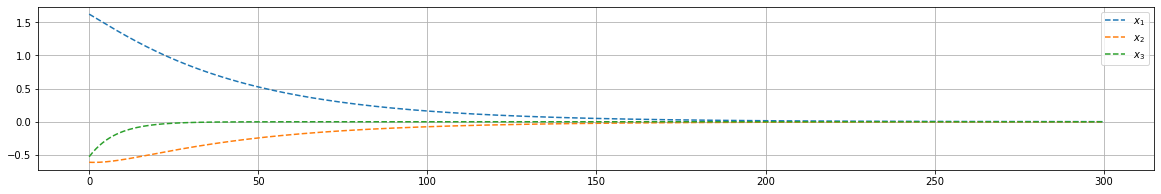

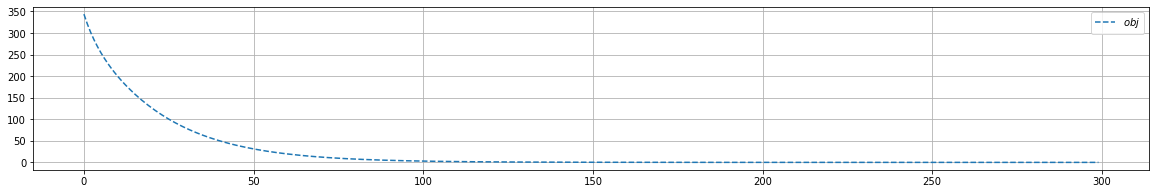

In [10]:
param["Q"] = np.eye(3) * 10
param["P"] = np.eye(3) * 100
param["R"] = np.eye(2) * 1

param["h"] = 0.02
param["mode"] = "LQR"

N_sim = 300
preview = 10
x0 = np.random.randn(3, 1)
x_log, u_log, obj_log = sim_LinSys_cl(x0, Ad, Bd, lambda x, u, xinit: Controller(x, u, xinit, Jac_Lin, param), N_sim, preview, noisy = False)

plt.figure(figsize=(20, 3))
plt.plot(x_log[:, 0], '--', label = "$x_1$")
plt.plot(x_log[:, 1], '--', label = "$x_2$")
plt.plot(x_log[:, 2], '--', label = "$x_3$")

plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(obj_log, '--', label = "$obj$")

plt.legend()
plt.grid()
plt.show()

## One-step MPC with well-designed terminal state cost

Remeber that the LQR for linear-time invariant system induces linear feedback $u_k := K x_k$. The we can find that the cost function for infinite-horizon takes the form:
$$
\begin{equation}
\begin{aligned}
J(x_0) &= \sum_{k=0}^{\infty}x_k^TQx_k + u_k^TRu_k \\
       &= \sum_{k=0}^{\infty}x_k^TQx_k + (Kx_k)^TR(Kx_k) \\
       &= \sum_{k=0}^{\infty}x_k^T(Q + K^TRK)x_k \\
\end{aligned}
\end{equation}
$$

Note the closed-loop system induces by this feedback:

$$
x_{k+1} = (A + BK)x_k=: A_cx_k. 
$$

Thus we can represent $J(x_0)$ as a quadratic function of the initial state $x_0$:

$$
x_k = A_c^{k}x_0, k = 1, 2, \cdots ,
$$
$$
\begin{equation}
\begin{aligned}
J(x_0) &= \sum_{k=0}^{\infty}x_k^T(Q + K^TRK)x_k \\
       &= \sum_{k=0}^{\infty}x_0(A_c^{k})^T(Q + K^TRK)A_c^kx_0 \\
       &= x_0^T \sum_{k=0}^{\infty}((A_c^{k})^T(Q + K^TRK)A_c^k) x_0 \\
       &:= x_0^T P x_0
\end{aligned}
\end{equation}
$$

If system $[A, B]$ is stabilizable, there exist such gain matrix $K$ to make this summation converges to the steady state value, which is defined as $P$. 

Now we use this function as our terminal cost to represent the expected cost for infinitely long horizon. 

C:\Users\Sangli\AppData\Local\Temp\ipykernel_22508\2515087929.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.array([np.random.randn(1), np.random.randn(1), 1.99])


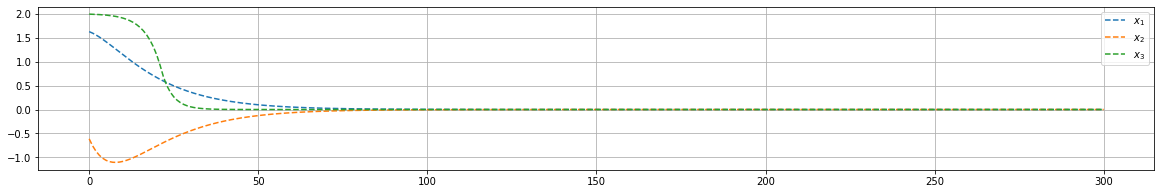

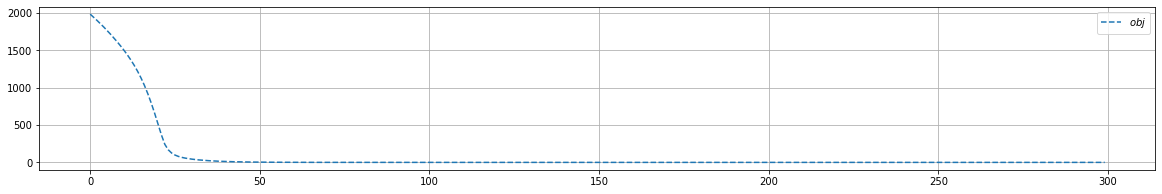

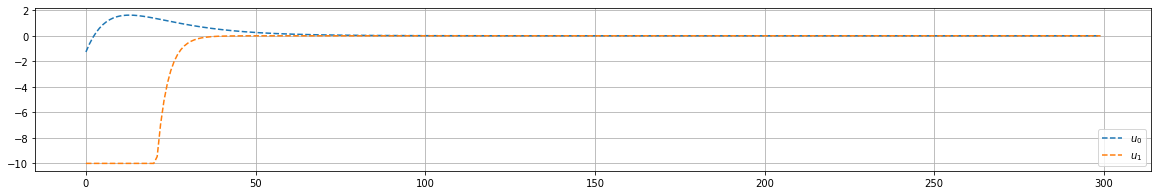

In [11]:
param["P"] = np.array([ [645.4953,  122.3307,   -0.],
                        [122.3307,  199.8055,    0.],
                        [0, 0, 578.2350 ] ])

param["mode"] = "MPC"
param["ub"] = np.array([10, 10]) 
param["lb"] = np.array([-10, -10])

N_sim = 300
preview = 1
# x0 = np.random.randn(3, 1)
x0 = np.array([np.random.randn(1), np.random.randn(1), 1.99])
x_log, u_log, obj_log = sim_LinSys_cl(x0, Ad, Bd, lambda x, u, xinit: Controller(x, u, xinit, Jac_Lin, param), N_sim, preview, noisy = False)

##
plt.figure(figsize=(20, 3))
plt.plot(x_log[:, 0], '--', label = "$x_1$")
plt.plot(x_log[:, 1], '--', label = "$x_2$")
plt.plot(x_log[:, 2], '--', label = "$x_3$")

plt.legend()
plt.grid()
plt.show()

##
plt.figure(figsize=(20, 3))
plt.plot((obj_log), '--', label = "$obj$")

plt.legend()
plt.grid()
plt.show()

##
plt.figure(figsize=(20, 3))
plt.plot(u_log[:, 0], '--', label = "$u_0$")
plt.plot(u_log[:, 1], '--', label = "$u_1$")

plt.legend()
plt.grid()
plt.show()


## The problem of this theory. 

1. The $\mathcal{X}_f$ is not trivial. This is why MPC with state constraints often results in infeasibility. We will see this in the future example sessions using nonlinear MPC with state constraints. 

2. All the ayalysis are based on the assumption that the optimization can be solved with some level of optimality, which is not true for all the time. With bad initialization, the MPC may not have feasible solutions. Thus, the optimality is not guranteed. 

## Reference: 
[1]: Borrelli, F., Bemporad, A. and Morari, M., 2017. Predictive control for linear and hybrid systems. Cambridge University Press. https://drive.google.com/file/d/1zaaZZjoXm73klAWfC62YlrUzujJOXUMt/view